In [1]:
# get tweet from twint 
# prep raw text 

# do tokenize
# do vertorize 
# perform clustering
# show cluster 

# visual clusters
# interprete cluster 
# compare with searching "terms"


# problem statement
# explain all data from searching "terms"
# explian code and comments
# show visuals 
# explain interpretion 


# techniuqe 
# N-Gram
# K-Mean
# PCA/LDA

# SetUp

In [403]:
import os
import math
import pandas as pd
import numpy as np
import wikipedia
import marisa_trie
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
import texthero as hero

from wordcloud import WordCloud
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from pythainlp.corpus import thai_stopwords 
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words
from pythainlp.util import normalize
from pythainlp import word_vector

In [4]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/prachy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/prachy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
def change_matplotlib_font(font_download_url):
    FONT_PATH = 'MY_FONT'
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[0]).get_name()
    matplotlib.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])

In [3]:
font_download_url = "https://fonts.google.com/download?family=Noto%20Serif%20Thai"
change_matplotlib_font(font_download_url)

--2022-11-11 21:06:21--  https://fonts.google.com/download?family=Noto%20Serif%20Thai
Resolving fonts.google.com (fonts.google.com)... 2404:6800:4001:809::200e, 216.58.199.238
Connecting to fonts.google.com (fonts.google.com)|2404:6800:4001:809::200e|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘MY_FONT.zip’

     0K .......... .......... .......... .......... ..........  347K
    50K .......... .......... .......... .......... ..........  988K
   100K .......... .......... .......... .......... .......... 1.46M
   150K .......... .......... .......... .......... ..........  756K
   200K .......... .......... .......... .......... .......... 26.5M
   250K .......... .......... .......... .......... .......... 1.24M
   300K .......... .......... .......... .......... ..........  819K
   350K .......... .......... .......... .......... .......... 30.2M
   400K .......... .......... .......... .......... .......... 28.8

Archive:  MY_FONT.zip
  inflating: MY_FONT/OFL.txt         
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-Thin.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-ExtraLight.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-Light.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-Regular.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-Medium.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-SemiBold.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-Bold.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-ExtraBold.ttf  
  inflating: MY_FONT/static/NotoSerifThai_ExtraCondensed/NotoSerifThai_ExtraCondensed-Black.ttf  
  inflating: MY_FONT/static/NotoSerifThai_Con

In [85]:
pd.set_option('display.max_colwidth', None)

# Load Data

In [7]:
!ls 

Ch3Thailand.txt           brownclustering           text-clustering.ipynb
MY_FONT                   dataset                   text-mining.ipynb
MY_FONT.zip               piti                      text_classification.ipynb
THSarabunNew              play
brown-clustering          sna-project2.ipynb


In [496]:
raw_data1 = pd.read_csv('play/output.csv') # search by keyword กัญชาเสรี
raw_data2 = pd.read_csv('piti/output4.csv') # search by keyword กัญชาการแพทย์

In [497]:
raw_data2=raw_data2[['tweet']]

In [498]:
# raw_data1

In [499]:
# raw_data2

# EDA 

In [500]:
raw_data1.shape

(9219, 1)

In [501]:
raw_data2.shape

(100, 1)

In [502]:
raw_data1.columns=['tweet']

In [503]:
df = pd.concat([raw_data1, raw_data2], ignore_index=True).drop_duplicates()

In [504]:
backup_df = df.copy()

# Text PreProcessing

## Text Cleaning

In [529]:
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_special_char(text):
    special_char = r"""[~@<>,}{()*:;"'-+=_?"\"/$%^%$!ๆ‘’“”…่่่่่่่่่ạễ•′–0-9]"""
    text = re.sub(special_char, '', text)
    text = text.replace("[", '').replace("]", '').replace('-', '')
    return text

def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = text.lower().strip()
    text = replace_url(text)
    text = replace_special_char(text)
    text = remove_emoji(text)
    cleaned_text = normalize(text)

    return cleaned_text

In [530]:
df['cleaned_tweet'] = df['tweet'].map(clean_text)

In [531]:
df.sample(5)

,tweet,cleaned_tweet,token_tweet
3348,@kohsija กัญชารักษาโควิดแทน 😆,kohsija กัญชารักษาโควิดแทน,kohsija กัญชา รักษา โควิด แทน
8454,พร้อมส่งครับ..หาคนพร้อมโอน55 เพื่อนๆคนไหนสนใจลงทุนเอาไปทำต่อ Dmมาน่ะครับ เครดิตแน่นๆส่งจริงแน่นอน💯 #ลีนนอก #ลีน #ลีนแท้ #ลีนไทย #lean #กัญชาเชียงใหม่ #กัญชานอก #กัญชาเสรี #กัญชาog #กัญชากรุงเทพ #ยาแก้ไอ #ยานอนหลับแบบน้ำ #สายไฮ #สายตี้ #กรุงเทพธุรกิจออนไลน์ #นนทบุรี #พระประแดง https://t.co/5VSDoWaNrY,พร้อมสงครับ..หาคนพร้อมโอน เพือนคนไหนสนใจลงทุนเอาไปทำตอ dmมานะครับ เครดิตแนนสงจริงแนนอน #ลีนนอก #ลีน #ลีนแท้ #ลีนไทย #lean #กัญชาเชียงใหม #กัญชานอก #กัญชาเสรี #กัญชาog #กัญชากรุงเทพ #ยาแก้ไอ #ยานอนหลับแบบน้ำ #สายไฮ #สายตี้ #กรุงเทพธุรกิจออนไลน์ #นนทบุรี #พระประแดง xxurl,สง .. หา คน โอน เพือนคน สนใจ ลงทุน ทำ ตอ dm มานะ เครดิต แนน สง แนน อน ลี ลี ลี ลี ไทย lean กัญชาเชียงใหม กัญชานอก กัญชาเสรี กัญชา og กัญชากรุงเทพ ยาแก้ไอ ยานอนหลับ น้ำ สาย ไฮ สาย ตี้ กรุงเทพ ธุรกิจ ออนไลน์ นนทบุรี พระประแดง
5754,#กัญชาเชียงราย ชนมือเชียงราย หาพ่อค้าไปทำต่อครับ ไลน์ phachacr -Inzane Banana ส่ง180 - banana daddy ส่ง180 ค่ายEthos -Kosher Cake Auto Thc 25% จี300 ส่ง10จี จีละ250- ราคาเบาลง ชาร์ลอตต์ดรีม thc9.5 cbd8.5 พันธุ์ผสมผ่านบริษัท ขีด5000 จี60 ไลน์ https://t.co/jgoyxyFiwR https://t.co/tBd6N6JzM7,#กัญชาเชียงราย ชนมือเชียงราย หาพอค้าไปทำตอครับ ไลน์ phachacr inzane banana สง banana daddy สง คายethos kosher cake auto thc จี สงจี จีละ ราคาเบาลง ชาร์ลอตต์ดรีม thc. cbd. พันธุ์ผสมผานบริษัท ขีด จี ไลน์ xxurl xxurl,กัญชา เชียงราย ชน มือ เชียงราย หา ค้า ทำ ตอ ไลน์ phachacr inzane banana สง banana daddy สง คาย ethos kosher cake auto thc จี สง จี จี ราคา เบา ชา ร์ลอตต์ ดรีม thc cbd พันธุ์ผสม ผา นบ ริ ษัท ขีด จี ไลน์
8510,เกรด พรีเมี่ยม exotics สนใจinboxได้ครับ #กัญชา #กัญชานอก #กัญชาog #กัญชาโคราช #กัญชาเมา #กัญชาออแกนิค #ขายกัญชาเมา #สายเขียว #og #Salecannabis #กัญชาไทย #กัญชาราคาถูก https://t.co/qeEwPVzMzm,เกรด พรีเมียม exotics สนใจinboxได้ครับ #กัญชา #กัญชานอก #กัญชาog #กัญชาโคราช #กัญชาเมา #กัญชาออแกนิค #ขายกัญชาเมา #สายเขียว #og #salecannabis #กัญชาไทย #กัญชาราคาถูก xxurl,เกรด พรีเมียม exotics สนใจ inbox กัญชา กัญชานอก กัญชา og กัญชา โคราช กัญชา เมา กัญชาออแกนิค ขาย กัญชา เมา สาย เขียว og salecannabis กัญชา ไทย กัญชา ราคา
4957,@Maliisacat2 @Thamboon888 เหี้ยมากอะ หน้าตาแบบนี้ถ้าเด็กๆคิดว่ามันเป็นชาเขียวแล้วเผลอกินเข้าไปอะ ทุกวันนี้ต้องบอกลูกตลอดเวลาซื้อขนมกินถ้ามีรูปใบกัญชาห้ามซื้อกินเด็ดขาด เราต้องมาคอยสอนลูกให้ระวังของกินจากความคิดของคนที่เป็น รมต.อะ คิดดู,maliisacat thamboon เหี้ยมากอะ หน้าตาแบบนี้ถ้าเด็กคิดวามันเป็นชาเขียวแล้วเผลอกินเข้าไปอะ ทุกวันนี้ต้องบอกลูกตลอดเวลาซื้อขนมกินถ้ามีรูปใบกัญชาห้ามซื้อกินเด็ดขาด เราต้องมาคอยสอนลูกให้ระวังของกินจากความคิดของคนทีเป็น รมต.อะ คิดดู,maliisacat thamboon เหี้ย อะ หน้าตา แบบนี้ เด็ก วา ชาเขียว เผลอ กิน เข้าไป อะ ลูก ซื้อ ขนม กิน รูป ใบ กัญชา ห้าม ซื้อ กิน เด็ดขาด คอย สอน ลูก ระวัง ของกิน ความคิด คนที รมต. อะ คิดดู


## More Cleasing

In [532]:
added_words1 = ['ยกโล','ราคาส่ง','ครึ่งโล','กัญชาอัดแท่ง','งานดอกสายพันธุ์','มีของพร้อมส่งจริง','เนื้อล้วน']
added_words2 = ['ลอยกระทง','กัญชาอัดแทง','กัญชาเสรี','กัญชาการแพทย์','กัญชาออแกนิค','กลุ่ม','กัญชาทางการแพทย์','กัญชาไฟฟ้า','กัญชากรุงเทพ','การแพทย์','กัญชานอก','สายขียว']
added_words3 = ['กัญชาเชียงใหม','กัญชาขอนแกน','กัญชารามคําแหง','กัญชาลาดพร้าว','กัญชารามอินทรา','กัญชารังสิต','กัญชาออแกนิก']
added_words4 = ['สุทิน','ศุภชัย','อนุทิน','ภูมิใจไทย','ประชาธิปัตย์','ภูมิใจไทย','พ.ร.บ.สุราก้าวหน้า','ก้าวไกล','จุรินทร์','สาทิตย์','นิพนธ์','หางกระรอก',
                'หางเสือ','กัญชาอุบลราชธานี','กัญชารังสิต','กัญชานนทบุรี','กัญชาเมืองทอง','กัญชากรุงเทพ','กัญชานนทบุรี','กัญชาพัทยา','กัญชาลาดกระบัง','กัญชาบางนา',
               'กัญชากทม','กัญชาราชบุรี','สุราก้าวหน้า','ฝายค้าน','อิหนู','หมอหนู','กัญชาลําพูน']

punc1 = ['"','“','”','ๆ','!','-','\xa0•••',"‘",')','(','0','1','2','3','4','5','6','7','8','9','...','.','/',"’",':','%',"'",'#']
punc2 = ['\n','',' ', '⭐️' ,'?', '??','?‍♀️??‍♂️','❤️',':)','^ ^','^']
punc3 = ['✅','😡','@','✅✅', 'xxurl','🚨🚨','&gt;&gt;','🤤❤️‍🔥','✨ 🍰','🌞🍀','😅😅',
         '👉👉','❤️','��🏻','🤩🎉','💳','🥦','🍀✨','💯✅','💯','👇👇','👇','��',
        '🌳🔥😁','🔥','💯','️⃣️⃣ ️⃣️⃣️⃣','️⃣️⃣','✅✨','✅ ','🌱🌱','🛵📦']

final_punc = set(punc1 + punc2 + punc3)
final_added_words = set(added_words1 + added_words2 + added_words3 + added_words4)

In [533]:
print(final_punc)

{'', ':', ')', '%', '️⃣️⃣', '👇👇', '🛵📦', '✅ ', ' ', '✅✨', '2', '4', '✅', '@', '-', '^', '9', '🚨🚨', '🌞🍀', ':)', '🌱🌱', '8', '‘', '/', '🌳🔥😁', '’', '💯', '3', '.', '(', '️⃣️⃣ ️⃣️⃣️⃣', '”', '\xa0•••', '...', '?\u200d♀️??\u200d♂️', '5', '✅✅', 'xxurl', '🔥', '🍀✨', '✨ 🍰', '👇', '👉👉', '0', '\n', '⭐️', '1', '“', '😡', '💳', '"', '🥦', "'", '6', '🤤❤️\u200d🔥', '!', '7', '^ ^', '??', '&gt;&gt;', '?', 'ๆ', '��', '��🏻', '😅😅', '💯✅', '🤩🎉', '❤️', '#'}


In [534]:
print(final_added_words)

{'หางกระรอก', 'กัญชาอุบลราชธานี', 'กัญชาอัดแทง', 'กัญชาบางนา', 'กัญชานอก', 'เนื้อล้วน', 'สุทิน', 'มีของพร้อมส่งจริง', 'ลอยกระทง', 'ประชาธิปัตย์', 'กัญชานนทบุรี', 'กัญชาไฟฟ้า', 'กัญชาพัทยา', 'อนุทิน', 'กลุ่ม', 'กัญชาออแกนิค', 'ภูมิใจไทย', 'ฝายค้าน', 'สุราก้าวหน้า', 'ครึ่งโล', 'กัญชาออแกนิก', 'กัญชารามอินทรา', 'หางเสือ', 'กัญชารังสิต', 'จุรินทร์', 'กัญชากรุงเทพ', 'กัญชากทม', 'สาทิตย์', 'อิหนู', 'กัญชาลาดกระบัง', 'กัญชาลาดพร้าว', 'กัญชาราชบุรี', 'งานดอกสายพันธุ์', 'กัญชาทางการแพทย์', 'ศุภชัย', 'หมอหนู', 'กัญชาเสรี', 'การแพทย์', 'พ.ร.บ.สุราก้าวหน้า', 'กัญชาอัดแท่ง', 'กัญชาการแพทย์', 'นิพนธ์', 'กัญชาขอนแกน', 'สายขียว', 'ก้าวไกล', 'ราคาส่ง', 'ยกโล', 'กัญชาเชียงใหม', 'กัญชาเมืองทอง', 'กัญชาลําพูน', 'กัญชารามคําแหง'}


In [535]:
all_words = set(thai_words()) 

for word in final_added_words:
    all_words.add(normalize(word))

In [536]:
len(all_words)

62091

In [537]:
# file = open('Ch3Thailand.txt','w')

# for msg in df['message']:
#     # print(extract_words(msg,c_dict).strip())
#     file.write(extract_words(msg,c_dict).strip()+'\n')
# file.close()

In [541]:
# def tokenize(text):
#     tokenized_text = [word for word in word_tokenize(text) if word and not re.search(pattern=r"\s+", string=word)] # segment and not ' word '
#     return tokenized_text
c_dict = marisa_trie.Trie(all_words)

def cut_words(tweet):
    # atta-cut is default now
    words = word_tokenize(tweet, custom_dict=c_dict, keep_whitespace=False)
    words = [word for word in words if word not in final_punc]
    words = [word for word in words if word not in list(thai_stopwords())]
    words = [word for word in words if len(word) > 1]
    return ' '.join(words)

def extract_words(tweet):
    words = ''
    for token in tweet.split():
        if token[0] == '#':
            continue
        elif 'http' in token or 'www' in token:
            continue
        else:
            words += ' ' + cut_words(token)
        return words

In [543]:
# df['tokenized_tweet'] = 
df['token_tweet'] = df['cleaned_tweet'].map(cut_words)

In [544]:
df.sample(5)

,tweet,cleaned_tweet,token_tweet
7650,กัญชาเสรีก็หย่อนนะ,กัญชาเสรีก็หยอนนะ,กัญชาเสรี หยอน
6680,สยามเมืองยิ้ม ยิ้มเพราะกัญชาสิเอดอก ปวดหัว ชูเรื่องนี้มาแล้วน่าอับหาย ที่จริงนะที่จริง ส่งเสริมงานวิจัยตัวยาใหม่ๆ เทคโนโลยีใหม่ๆแบบสมัยก่อนน่าตะดีกว่า,สยามเมืองยิ้ม ยิ้มเพราะกัญชาสิเอดอก ปวดหัว ชูเรืองนี้มาแล้วนาอับหาย ทีจริงนะทีจริง สงเสริมงานวิจัยตัวยาใหม เทคโนโลยีใหมแบบสมัยกอนนาตะดีกวา,สยาม เมือง ยิ้ม ยิ้ม กัญชา สิ เอ ดอก ปวดหัว ชู เรือง แล้ วนา อับ หาย สง เสริม งานวิจัย ตัว ยา ใหม เทคโนโลยี ใหม กอ นา ตะ ดี กวา
3704,OG Kush (pop) 1g = 250฿ #กัญชา #กัญชาออแกนิค #กัญชากรุงเทพ #ชนมือ #ชนมือละแวกใกล้เคียง #ดอกโอจี #สาย2 #สาย3 #สาย4 #สาย5 #ศาลายา #เอกชัย #มหาชัย 🍁อัพเดทของ🍁 https://t.co/0uCKveeYid https://t.co/PZeI1dYKXS,og kush pop g ฿ #กัญชา #กัญชาออแกนิค #กัญชากรุงเทพ #ชนมือ #ชนมือละแวกใกล้เคียง #ดอกโอจี #สาย #สาย #สาย #สาย #ศาลายา #เอกชัย #มหาชัย อัพเดทของ xxurl xxurl,og kush pop กัญชา กัญชาออแกนิค กัญชากรุงเทพ #ชน มือ #ชน มือ ละแวก ใกล้เคียง ดอก โอจี สาย สาย สาย สาย ศาลา ยา เอก ชัย มหาชัย อัพเดท
4446,ถึงได้บอกว่าชั้นเจอกัญชาทุกที่ที่ไม่มีและไม่เกี่ยวกับแพทย์ งงมาก,ถึงได้บอกวาชั้นเจอกัญชาทุกทีทีไมมีและไมเกียวกับแพทย์ งงมาก,บอ กวา ชั้น เจอ กัญชา ไม ไม เกีย แพทย์ งง
2535,เริ่มปรับไฟทำดอก week 1 #กัญชา #กัญชาโอจี #กัญชาออแกนิค #กัญชาขอนแก่น https://t.co/Ux39i6LuK4,เริมปรับไฟทำดอก week #กัญชา #กัญชาโอจี #กัญชาออแกนิค #กัญชาขอนแกน xxurl,เริม ไฟ ทำ ดอก week กัญชา กัญชา โอจี กัญชาออแกนิค กัญชาขอนแกน


In [545]:
df.shape

(9239, 3)

# Modeling

## Vertorization

In [546]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split())
X = vectorizer.fit_transform(df['token_tweet'])

In [547]:
X.shape

(9239, 11797)

In [548]:
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

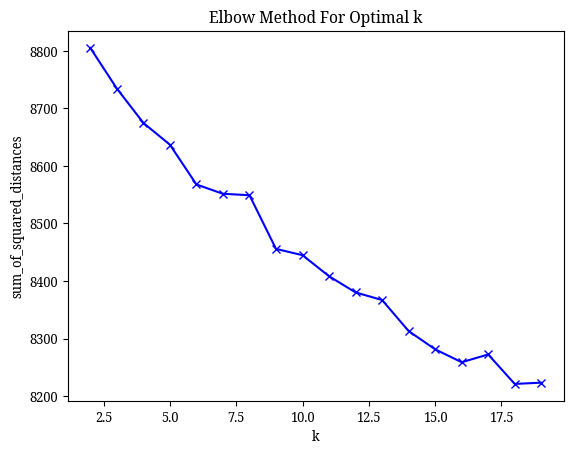

In [549]:
err = []
start_k=2
max_k=20

for k in range(start_k, max_k):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10).fit(X)
    err.append(km.inertia_)
    
plt.plot([i for i in range(start_k,max_k)], err, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### K Mean Clustering

In [550]:
true_k=15
km=KMeans(n_clusters=true_k).fit(X)
c=km.cluster_centers_

In [551]:
sorted(Counter(list(km.labels_)).most_common())

[(0, 63),
 (1, 951),
 (2, 3414),
 (3, 209),
 (4, 530),
 (5, 437),
 (6, 118),
 (7, 589),
 (8, 347),
 (9, 128),
 (10, 1440),
 (11, 63),
 (12, 123),
 (13, 179),
 (14, 648)]

In [552]:
# get centroid and order 
for i in range(true_k):
    print("cluster:#{}".format(i))
    word_tuples = [(c[i][j],vectorizer.get_feature_names()[j]) for j in range(len(c[i]))]
    word_tuples.sort(reverse=True)
    print(' '.join([str(j) for i,j in word_tuples[:10]]))
    print("-----")

cluster:#0


/Users/prachy/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



อน งบ แนน การันตี นครพนม รีบ แห้ ฉำไม มดี กอ
-----
cluster:#1
กัญชา สง ราคา กัญชากรุงเทพ กัญชาเชียงใหม กัญชาอัดแทง สัง og กัญชาเสรี กัญชานอก
-----
cluster:#2
กัญชา กัญชาเสรี เพือ เมา ผม กวา ขาย แต กัญชาทางการแพทย์ อุบล
-----
cluster:#3
กัญชา og พันลำ กัญชาออแกนิค กัญชานอก กัญชานนทบุรี กัญชากรุงเทพ exotic ดอก บี
-----
cluster:#4
สาย กัญชา เขียว cannabis og กัญชาอัดแทง กัญชาออแกนิค weed thc พันลำ
-----
cluster:#5
กัญชาเชียงใหม เชียง ขีด ใหม กัญชา นัด ครึ สง มือ og
-----
cluster:#6
พันลำ กัญชาเมืองทอง greeninferno og กัญชา เกร็ด เมือง ทอง ปาก funkush
-----
cluster:#7
ผา อนุทิน สุราก้าวหน้า กัญชา ไม ขาว พรรค ราง การเมือง สภา
-----
cluster:#8
เสรี matichononline แต กัญชา สุรา ไม กัญชาเสรี ลอย เหล้า นายทุน
-----
cluster:#9
จังหวัด ตาง เขต ลาดพร้าว คลิก รัชดา กรุงเทพ og กัญชา ขาย
-----
cluster:#10
ไม วา กัญชา แต คน กิน กวา อะ ใส ยู
-----
cluster:#11
แคป ชัน ทัก เด็ด ซึมเศร้า โรค สนใจ ไลน์ ไฟฟ้า น้ำมัน
-----
cluster:#12
รัชดา ogganja ratchada day โชค delivery ชัย line บัตรเครดิต ชำระ
-----
clu

In [555]:
result={'cluster':km.labels_, 'message':df['token_tweet']}
result=pd.DataFrame(result)

In [558]:
result.sample(5)

,cluster,message
6041,2,อาร์ เมา กัญชา โหวต ปะ วะ กิน ม้า คึก
1822,1,โปรโมชัน แถม สง ฟรี สัง ซื้อ กัญชา กัญชาเชียงใหม กัญชากรุงเทพ กัญชารามคำแหง กัญชาลาดกระบัง กัญชา เขน
9103,3,oz .. สัง ติด ตอ .. กัญชาออแกนิค กัญชา og กัญชารังสิต กัญชานอก กัญชากทม กัญชา พันลำ og #คีฟ กัญชาเมืองทอง cannabis weedlovers กัญชาเชียงใหม กัญชา ราคา สง กัญชา สมุทรปราการ กัญชา โอจี กัญชากรุงเทพ
1157,2,ปากกา น้ำมัน thc แรง ตา แตก ครับผม thc vape น้ำมัน กัญชา กัญชาไฟฟ้า กัญชา cbd thcvape cannabis thaicannabis
4335,7,จุรินทร์ ย้ำ ประชาธิปัตย์ เดินหน้า วิถี ประชาธิปไตย เคารพ ความเห็น ตาง ไม หนุน กัญชาเสรี พรรคประชาธิปัตย์ กัญชาเสรี จุรินทร์ พรรค รัฐบาล พรรคภูมิใจไทย


### wordCloud

In [559]:
!ls ./THSarabunNew/THSarabunNew.ttf

./THSarabunNew/THSarabunNew.ttf


In [560]:
path = './THSarabunNew/THSarabunNew.ttf'

In [561]:
regexp = r"[ก-๙a-zA-Z']+"

In [562]:
df2=result.copy()

Cluster: 0


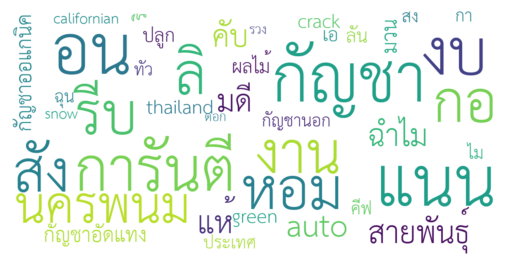

Cluster: 1


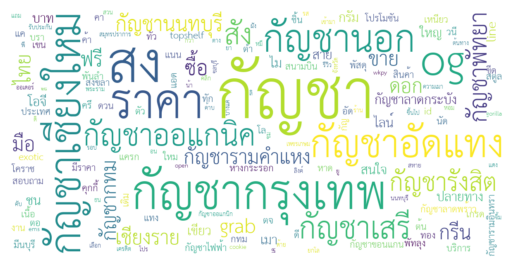

Cluster: 2


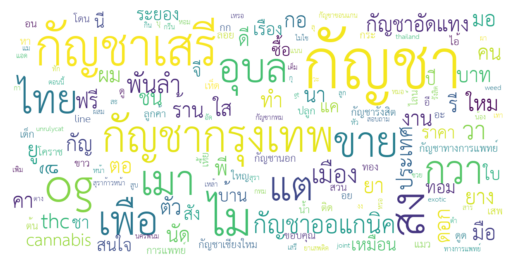

Cluster: 3


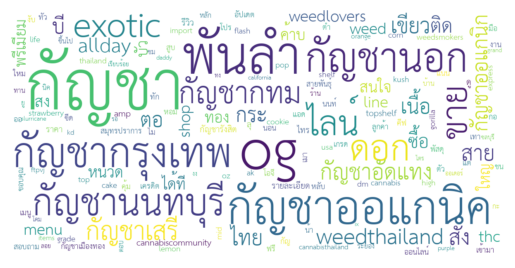

Cluster: 4


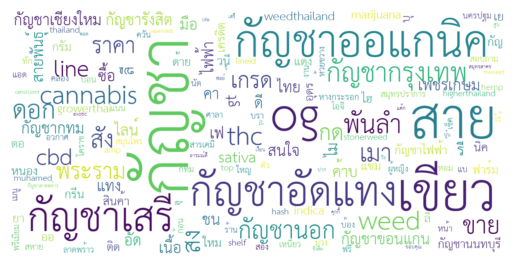

Cluster: 5


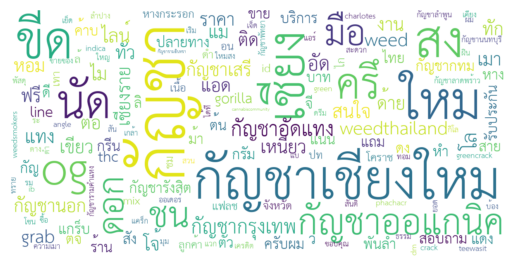

Cluster: 6


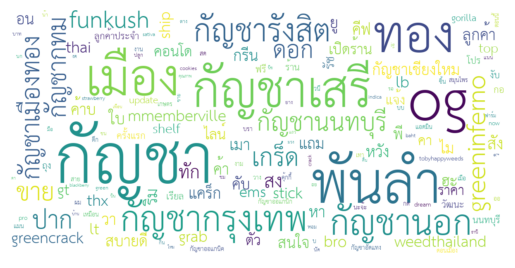

Cluster: 7


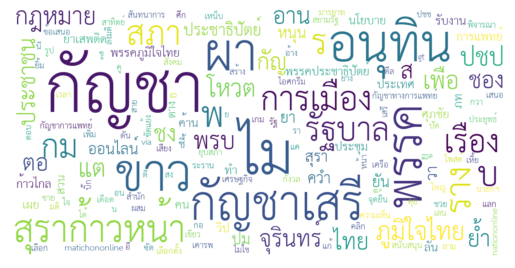

Cluster: 8


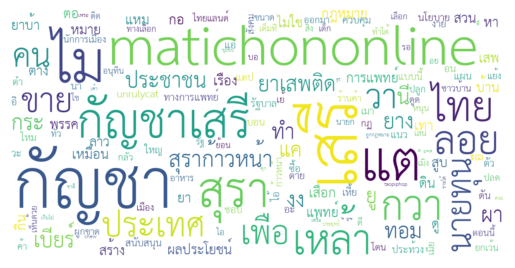

Cluster: 9


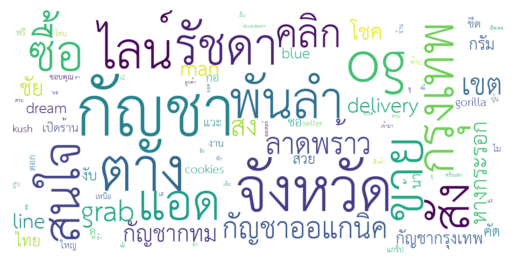

Cluster: 10


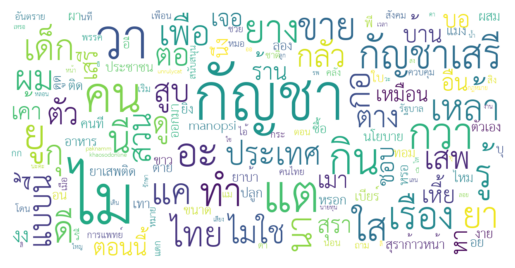

Cluster: 11


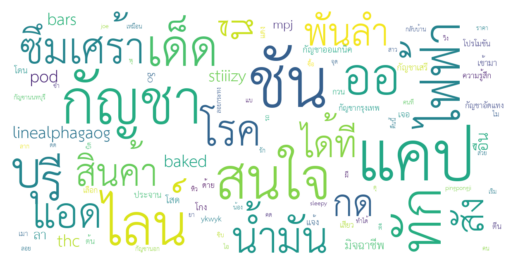

Cluster: 12


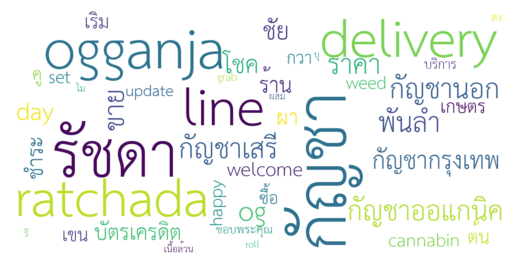

Cluster: 13


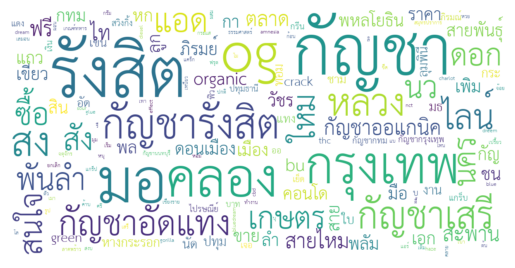

Cluster: 14


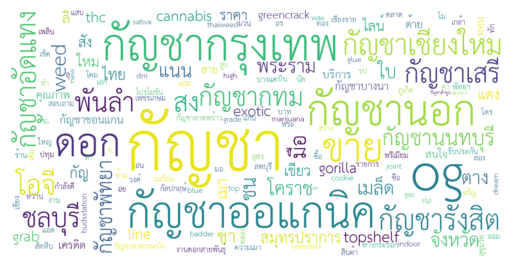

In [563]:
for k in range(0, true_k):
    s=result[result.cluster==k]
    text=s['message'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(font_path=path, 
                          relative_scaling=0.3,
                          max_font_size=80, 
                          max_words=150, 
                          min_font_size=2,
                          background_color="white",
                          collocations=False,
                          scale=3,
                          font_step=4,
                          regexp=regexp,
                          margin=2
                         ).generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Interpretion

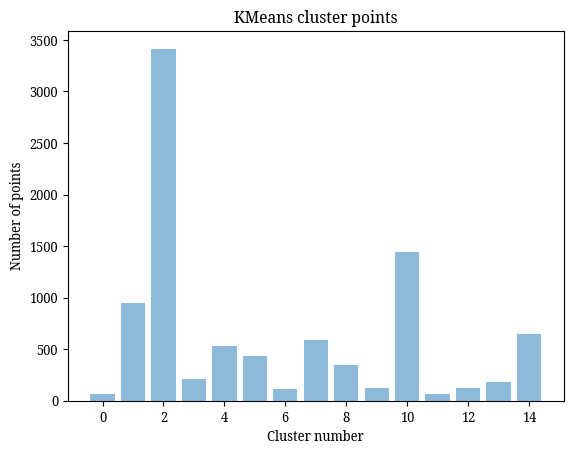

In [564]:
# visually how data points distributed across K clusters 
plt.bar([x for x in range(true_k)], df2.groupby(['cluster'])['message'].count(), alpha = 0.5)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

## [**Note not done**] use seaborn to visual cluster

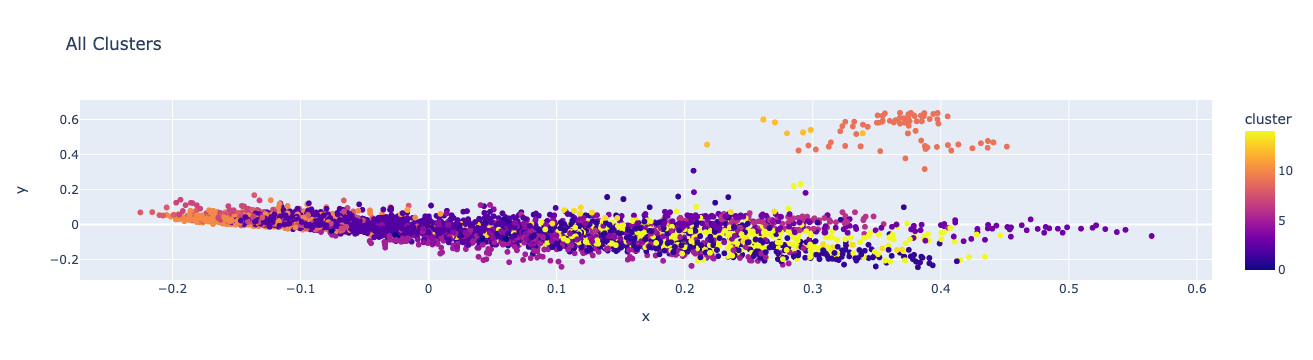

In [565]:
df2['pca'] = (
    df2['message']
    .pipe(hero.clean)
    .pipe(hero.tfidf)
    .pipe(hero.pca)
)

hero.scatterplot(df2, col='pca', color='cluster', title="All Clusters")

## [**Note not done**] do more to extract keywords in each cluster

In [569]:
sentence=[]
text_5=df2[df2['cluster']==12]['message'].apply(lambda x: sentence.append(x))
text_5=[''.join(sentence)][0]

In [570]:
from pythainlp import sent_tokenize
from pythainlp.util import find_keyword

sentence_5=sent_tokenize(text_5, engine="whitespace+newline")

In [571]:
kw = find_keyword(sentence_5, min_len=1)
sorted(kw.items(), key=lambda item: item[1], reverse=True)[0:10]

[('กัญชา', 369),
 ('รัชดา', 246),
 ('ogganja', 169),
 ('delivery', 123),
 ('ratchada', 123),
 ('line', 123),
 ('กัญชาออแกนิค', 123),
 ('กัญชาเสรี', 123),
 ('ราคา', 123),
 ('กัญชานอก', 123)]